In [1]:
import random
from collections import Counter
from os import path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

# from community import community_louvain
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
from torch_geometric.data import Batch, Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx
from torch_scatter import scatter_mean
from torch.nn.utils import clip_grad_norm_
from torch_geometric.utils import to_undirected
from torch_geometric.nn import dense_mincut_pool, dense_diff_pool
from torch_geometric import utils
from torch.nn import Linear
from sklearn.metrics import normalized_mutual_info_score

from dataset import create_dataset

In [2]:
def acc_f1(output, labels, average="binary", logging=None, verbose=True):
    preds = output.max(1)[1].type_as(labels)
    if preds.is_cuda:
        preds = preds
        labels = labels
    accuracy = accuracy_score(preds, labels)
    f1 = f1_score(preds, labels, average=average)
    return accuracy, f1


def dynamic_partition(data, partitions, num_partitions):
    res = []
    for i in range(num_partitions):
        res.append(data[torch.where(partitions == i)])
    return res


def adj_matrix_to_edge_index(adj_matrix, device=None):
    edge_index = [[], []]
    for i, row in enumerate(adj_matrix.detach().numpy().tolist()):
        for j, cell_value in enumerate(row[i + 1 :]):
            if cell_value == 1:
                edge_index[0].append(i)
                edge_index[1].append(j)
        edge_index[0].append(i)
        edge_index[1].append(i)
    edge_index = torch.tensor(edge_index, dtype=torch.int64)
    if device:
        edge_index = edge_index.to(device)
    return edge_index


def trim_feats(feats, sizes):
    stacked_num_nodes = sum(sizes)
    stacked_tree_feats = torch.zeros(
        (stacked_num_nodes, feats.shape[-1]), dtype=torch.float64
    )
    start_index = 0
    for i, size in enumerate(sizes):
        end_index = start_index + size
        stacked_tree_feats[start_index:end_index, :] = feats[i, :size, :]
        start_index = end_index
    return stacked_tree_feats


def create_batch(sizes):
    sizes = sizes.tolist()
    sizes = list(map(int, sizes))
    batch = []
    for i, size in enumerate(sizes):
        batch.extend([i] * size)
    batch = torch.tensor(batch, dtype=torch.int64)
    return batch


def pairwise_cosine_similarity(a, b):
    a_norm = a / torch.norm(a, dim=1).unsqueeze(-1)
    b_norm = b / torch.norm(b, dim=1).unsqueeze(-1)
    res = torch.matmul(a_norm, b_norm.transpose(-2, -1))
    return res


def compute_cross_attention(x_i, x_j):
    a = pairwise_cosine_similarity(x_i, x_j)
    a_i = F.softmax(a, dim=1)
    a_j = F.softmax(a, dim=0)
    att_i = torch.matmul(a_i, x_j)
    att_j = torch.matmul(a_j.T, x_i)
    return att_i, att_j, a_i, a_j


def batch_block_pair_attention(data, batch, n_graphs):
    all_attention_x = []
    all_attention_y = []
    all_a_i = []
    all_a_j = []

    for i in range(0, n_graphs, 2):
        x_i = data[batch == i]
        x_j = data[batch == i + 1]

        attention_x, attention_y, a_i, a_j = compute_cross_attention(x_i, x_j)

        all_attention_x.append(attention_x)
        all_attention_y.append(attention_y)
        all_a_i.append(a_i)
        all_a_j.append(a_j)

    result_x = torch.cat(all_attention_x, dim=0)
    result_y = torch.cat(all_attention_y, dim=0)
    # result_a_i = torch.cat(all_a_i, dim=0) if len(all_a_i) > 0 else torch.Tensor()
    # result_a_j = torch.cat(all_a_j, dim=0) if len(all_a_j) > 0 else torch.Tensor()

    result = torch.cat([result_x, result_y], dim=0)

    return result, all_a_i, all_a_j

In [3]:
def spectral_clustering(edge_index, num_nodes, num_clusters=10):
    adjacency_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float)
    adjacency_matrix[edge_index[0], edge_index[1]] = 1
    adjacency_matrix_np = adjacency_matrix.numpy()
    clustering = SpectralClustering(
        n_clusters=num_clusters, affinity="precomputed", assign_labels="discretize"
    ).fit(adjacency_matrix_np)
    return clustering.labels_

In [4]:
def cdm(node_embeddings, epsilon=1e-6, tau=0.5):
    exp_embeddings = torch.exp(node_embeddings)
    sum_exp_embeddings = torch.sum(exp_embeddings, dim=1, keepdim=True)
    q_i_tilde = exp_embeddings / sum_exp_embeddings
    max_q_i_tilde = torch.max(q_i_tilde, dim=1, keepdim=True).values
    q_i = q_i_tilde / (max_q_i_tilde + epsilon)
    r_i = (q_i >= tau).int()
    class_assignments = r_i.tolist()
    node_classes = [
        assignment.index(1) if 1 in assignment else -1
        for assignment in class_assignments
    ]

    return torch.tensor(node_classes)

In [5]:
def pyg_cluster(features, edge_index, node_clusters):
    unique_clusters = node_clusters.unique()
    supernode_features = []
    node_to_supernode = torch.empty(node_clusters.size(0), dtype=torch.long)
    for i, cluster in enumerate(unique_clusters):
        cluster_mask = node_clusters == cluster
        cluster_features = features[cluster_mask]
        supernode_feature = cluster_features.mean(dim=0)
        supernode_features.append(supernode_feature)
        node_to_supernode[cluster_mask] = i
    supernode_features = torch.stack(supernode_features, dim=0)

    supernode_edges = []
    for edge in edge_index.t():
        supernode_u = node_to_supernode[edge[0]]
        supernode_v = node_to_supernode[edge[1]]
        if supernode_u != supernode_v:
            supernode_edges.append([supernode_u, supernode_v])
    supernode_edges = torch.tensor(supernode_edges, dtype=torch.long).t()

    supernode_edges = to_undirected(supernode_edges, num_nodes=len(unique_clusters))

    clustered_data = Data(x=supernode_features, edge_index=supernode_edges)

    return clustered_data

In [6]:
class GraphMatchingConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels, args, aggr="add"):
        super(GraphMatchingConvolution, self).__init__(aggr=aggr)
        self.args = args
        self.lin_node = torch.nn.Linear(in_channels, out_channels)
        self.lin_message = torch.nn.Linear(out_channels * 2, out_channels)
        self.lin_passing = torch.nn.Linear(out_channels + in_channels, out_channels)
        self.batch_norm = BatchNorm(out_channels)

    def forward(self, x, edge_index, batch):
        x_transformed = self.lin_node(x)
        return self.propagate(edge_index, x=x_transformed, original_x=x, batch=batch)

    def message(self, edge_index_i, x_i, x_j):
        x = torch.cat([x_i, x_j], dim=1)
        m = self.lin_message(x)
        return m

    def update(self, aggr_out, edge_index, x, original_x, batch):
        n_graphs = torch.unique(batch).shape[0]
        cross_graph_attention, a_x, a_y = batch_block_pair_attention(
            original_x, batch, n_graphs
        )
        attention_input = original_x - cross_graph_attention
        aggr_out = self.lin_passing(torch.cat([aggr_out, attention_input], dim=1))
        aggr_out = self.batch_norm(aggr_out)
        return aggr_out, edge_index, batch, (cross_graph_attention, a_x, a_y)


class GraphAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels, args):
        super(GraphAggregator, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.lin_gate = torch.nn.Linear(in_channels, out_channels)
        self.lin_final = torch.nn.Linear(out_channels, out_channels)
        self.args = args

    def forward(self, x, edge_index, batch):
        x_states = self.lin(x)
        x_gates = torch.nn.functional.softmax(self.lin_gate(x), dim=1)
        x_states = x_states * x_gates
        x_states = scatter_mean(x_states, batch, dim=0)
        x_states = self.lin_final(x_states)
        return x_states

In [7]:
class GraphMatchingNetwork(torch.nn.Module):
    def __init__(self, args):
        super(GraphMatchingNetwork, self).__init__()
        self.args = args
        self.margin = self.args.margin
        if args.n_classes > 2:
            self.f1_average = "micro"
        else:
            self.f1_average = "binary"
        self.layers = torch.nn.ModuleList()
        self.layers.append(
            GraphMatchingConvolution(self.args.feat_dim, self.args.dim, args)
        )
        for _ in range(self.args.num_layers - 1):
            self.layers.append(
                GraphMatchingConvolution(self.args.dim, self.args.dim, args)
            )
        self.aggregator = GraphAggregator(self.args.dim, self.args.dim, self.args)
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.mincut = []
        self.mlp = torch.nn.Sequential()
        self.mlp.append(Linear(self.args.dim, self.args.n_clusters))

    def compute_emb(
        self, feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
    ):
        for i in range(self.args.num_layers):
            feats, edge_index, batch, cross_graph_attention = self.layers[i](
                feats, edge_index, batch
            )
            x_first_graph = feats[: sizes_1.item(), :]
            x_second_graph = feats[sizes_1.item() : sizes_1.item() + sizes_2.item(), :]
            clusters_1 = cdm(x_first_graph)
            s_first_graph = self.mlp(x_first_graph)
            self.layer_outputs.append((x_first_graph, x_second_graph))
            self.layer_cross_attentions.append(cross_graph_attention)
            adj = utils.to_dense_adj(edge_index_1).float()
            x_pooled, adj_pooled, mc_loss, o_loss = dense_diff_pool(
                x_first_graph, adj, s_first_graph
            )
            self.mincut.append((x_pooled, adj_pooled, mc_loss, o_loss))

        feats = self.aggregator(feats, edge_index, batch)
        return feats, edge_index, batch

    def combine_pair_embedding(
        self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
    ):
        feats = torch.cat([feats_1, feats_2], dim=0)
        max_node_idx_1 = sizes_1.sum()
        edge_index_2_offset = edge_index_2 + max_node_idx_1
        edge_index = torch.cat([edge_index_1, edge_index_2_offset], dim=1)
        batch = create_batch(torch.cat([sizes_1, sizes_2], dim=0))
        feats, edge_index, batch = (
            feats.to(self.args.device),
            edge_index.to(self.args.device),
            batch.to(self.args.device),
        )
        return feats, edge_index, batch

    def forward(self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2):
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.mincut = []
        feats, edge_index, batch = self.combine_pair_embedding(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )
        emb, _, _ = self.compute_emb(
            feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
        )
        emb_1 = emb[: emb.shape[0] // 2, :]
        emb_2 = emb[emb.shape[0] // 2 :, :]
        return emb_1, emb_2

    def compute_metrics(self, emb_1, emb_2, labels):
        distances = torch.norm(emb_1 - emb_2, p=2, dim=1)
        loss = F.relu(self.margin - labels * (1 - distances)).mean()
        predicted_similar = torch.where(
            distances < self.args.margin,
            torch.ones_like(labels),
            -torch.ones_like(labels),
        )
        acc = (predicted_similar == labels).float().mean()
        metrics = {"loss": loss, "acc": acc}
        return metrics

    def init_metric_dict(self):
        return {"acc": -1, "f1": -1}

    def has_improved(self, m1, m2):
        return m1["acc"] < m2["acc"]

In [8]:
def analyze_dataset(dataset):
    num_graphs = len(dataset)
    num_classes = dataset.num_classes if hasattr(dataset, "num_classes") else None
    num_node_features = (
        dataset.num_node_features if hasattr(dataset, "num_node_features") else None
    )
    labels = [data.y.item() for data in dataset]
    num_nodes = [data.num_nodes for data in dataset]
    class_distribution = Counter(labels)
    avg_num_nodes = sum(num_nodes) / len(num_nodes)
    min_nodes = min(num_nodes)
    max_nodes = max(num_nodes)

    small_threshold = 30
    large_threshold = 60

    small_graphs = []
    medium_graphs = []
    large_graphs = []

    classes = {
        "class_0": [],
        "class_1": [],
        "class_2": [],
        "class_3": [],
        "class_4": [],
        "class_5": [],
    }

    for i in dataset:
        c = i.y
        class_name = "class_" + str(c.item())
        classes[class_name].append(i)

    print(f"Total number of graphs: {num_graphs}")
    if num_classes:
        print(f"Number of classes: {num_classes}")
    if num_node_features:
        print(f"Number of node features: {num_node_features}")
    print(f"Average number of nodes per graph: {int(avg_num_nodes)}")
    print(f"Max number of nodes in a graph: {max_nodes}")
    print(f"Min number of nodes in a graph: {min_nodes}")

    print("Class distribution:")
    for cls, count in class_distribution.items():
        print(f" - Class {cls}: {count} graphs ({100 * count / num_graphs:.2f}%)")

    plt.figure(figsize=(10, 6))
    plt.hist(num_nodes, bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Distribution of Number of Nodes in {dataset.name} Dataset")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    for graph in dataset:
        if graph.num_nodes < small_threshold:
            small_graphs.append(graph)
        elif graph.num_nodes > large_threshold:
            large_graphs.append(graph)
        else:
            medium_graphs.append(graph)

    print(f"Small graphs: {len(small_graphs)}")
    print(f"Medium graphs: {len(medium_graphs)}")
    print(f"Large graphs: {len(large_graphs)}")

    return small_graphs, medium_graphs, large_graphs, classes

Total number of graphs: 180
Number of classes: 5
Number of node features: 4
Average number of nodes per graph: 11
Max number of nodes in a graph: 13
Min number of nodes in a graph: 10
Class distribution:
 - Class 1: 36 graphs (20.00%)
 - Class 0: 36 graphs (20.00%)
 - Class 2: 36 graphs (20.00%)
 - Class 3: 36 graphs (20.00%)
 - Class 4: 36 graphs (20.00%)


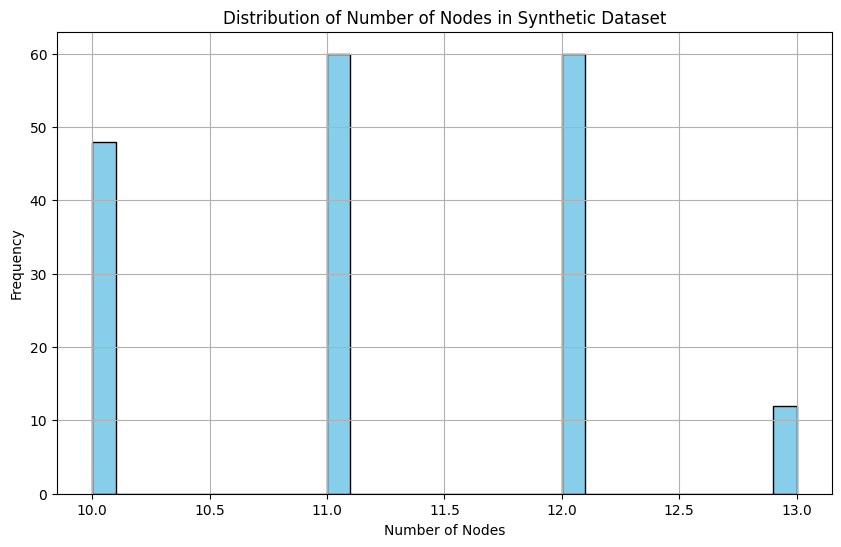

Small graphs: 180
Medium graphs: 0
Large graphs: 0


In [9]:
# dataset = TUDataset(
#     root="data", name="MUTAG", use_node_attr=True, transform=NormalizeFeatures()
# )

dataset = create_dataset()

small_graphs, medium_graphs, large_graphs, classes = analyze_dataset(dataset)

In [10]:
class Args:
    def __init__(self):
        self.dim = 32
        self.feat_dim = dataset.num_features
        self.num_layers = 6
        self.margin = 0.5
        self.lr = 0.001
        self.n_classes = dataset.num_classes
        self.batch_size = 128
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_clusters = 10


args = Args()

In [11]:
def create_graph_pairs(dataset, num_pairs=20000):
    pairs = []
    labels = []
    for _ in range(num_pairs):
        idx1, idx2 = random.sample(range(len(dataset)), 2)
        graph1, graph2 = dataset[idx1], dataset[idx2]

        label = 1 if graph1.y == graph2.y else -1
        pairs.append((graph1, graph2))
        labels.append(label)
    return pairs, labels


def collate_graph_pairs(batch):
    graph1_list, graph2_list, labels = [], [], []
    for (graph1, graph2), label in batch:
        graph1_list.append(graph1)
        graph2_list.append(graph2)
        labels.append(label)

    batched_graph1 = Batch.from_data_list(graph1_list)
    batched_graph2 = Batch.from_data_list(graph2_list)
    labels = torch.tensor(labels)
    return batched_graph1, batched_graph2, labels


pairs, labels = create_graph_pairs(dataset)
pair_dataset = [(pair, label) for pair, label in zip(pairs, labels)]
train_loader = DataLoader(
    pair_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    collate_fn=collate_graph_pairs,
)

In [12]:
def plot_graphs(edge_index, layer_clusters, graph1, graph2, sim, title=""):
    num_rows = len(layer_clusters)
    fig, axes = plt.subplots(num_rows, 4, figsize=(32, num_rows * 8))

    if num_rows > 1:
        x_pos = (
            axes[0][1].get_position().x1
            + (axes[0][2].get_position().x0 - axes[0][1].get_position().x1) / 2
        )
        fig.patches.extend(
            [
                plt.Rectangle(
                    (x_pos, 0), 0.001, 0.95, transform=fig.transFigure, color="black"
                )
            ]
        )
        fig.text(
            0.25, 0.95, f"Graph1 ({graph1})", ha="center", va="center", fontsize=17
        )
        fig.text(
            0.75, 0.95, f"Graph2 ({graph2})", ha="center", va="center", fontsize=17
        )
        fig.text(0.5, 0.97, f"Sim: {sim}", ha="center", va="center", fontsize=17)
    else:
        x_pos = (
            axes[1].get_position().x1
            + (axes[2].get_position().x0 - axes[1].get_position().x1) / 2
        )
        fig.patches.extend(
            [
                plt.Rectangle(
                    (x_pos, 0), 0.001, 0.9, transform=fig.transFigure, color="black"
                )
            ]
        )
        fig.text(0.25, 0.9, f"Graph1 ({graph1})", ha="center", va="center", fontsize=17)
        fig.text(0.75, 0.9, f"Graph2 ({graph2})", ha="center", va="center", fontsize=17)
        fig.text(0.5, 0.95, f"Sim: {sim}", ha="center", va="center", fontsize=17)

    fig.suptitle(title, fontsize=20, va="bottom", ha="center")

    axes = axes.flatten()

    def draw_graph(ax, G, title, node_colors):
        pos = nx.spring_layout(G)
        if node_colors:
            nx.draw(
                G,
                pos,
                ax=ax,
                with_labels=True,
                node_color=node_colors,
                cmap=plt.get_cmap("viridis"),
            )
        else:
            nx.draw(G, pos, ax=ax, with_labels=True)
        ax.set_title(title)

    for i, clusters in enumerate(layer_clusters):
        ax_index = 4 * i
        G_clustered = nx.Graph()
        for source, target in edge_index[0].T:
            G_clustered.add_edge(int(source), int(target))
        node_colors = [clusters[0][node] for node in G_clustered.nodes()]
        axes[ax_index].set_axis_off()
        draw_graph(axes[ax_index], G_clustered, f"Layer {i+1}", node_colors=node_colors)
        ax_index = 4 * i + 1
        G = nx.Graph()
        G.add_edges_from(edge_index[0].t().tolist())
        supernode_mapping = {node: int(cls) for node, cls in enumerate(clusters[0])}
        supergraph = nx.Graph()
        for cls in torch.unique(clusters[0]):
            supergraph.add_node(cls.item())
        for n1, n2 in G.edges():
            sn1, sn2 = supernode_mapping[n1], supernode_mapping[n2]
            if sn1 != sn2:
                supergraph.add_edge(sn1, sn2)
        axes[ax_index].set_axis_off()
        draw_graph(axes[ax_index], supergraph, f"Layer {i+1} Clustered", None)

        ax_index = 4 * i + 2
        G_clustered = nx.Graph()
        for source, target in edge_index[1].T:
            G_clustered.add_edge(int(source), int(target))
        node_colors = [clusters[1][node] for node in G_clustered.nodes()]
        axes[ax_index].set_axis_off()
        draw_graph(axes[ax_index], G_clustered, f"Layer {i+1}", node_colors=node_colors)
        ax_index = 4 * i + 3
        G = nx.Graph()
        G.add_edges_from(edge_index[1].t().tolist())
        supernode_mapping = {node: int(cls) for node, cls in enumerate(clusters[1])}
        supergraph = nx.Graph()
        for cls in torch.unique(clusters[1]):
            supergraph.add_node(cls.item())
        for n1, n2 in G.edges():
            sn1, sn2 = supernode_mapping[n1], supernode_mapping[n2]
            if sn1 != sn2:
                supergraph.add_edge(sn1, sn2)
        axes[ax_index].set_axis_off()
        draw_graph(axes[ax_index], supergraph, f"Layer {i+1} Clustered", None)

    plt.tight_layout()
    if num_rows > 1:
        fig.subplots_adjust(top=0.9)
    else:
        fig.subplots_adjust(top=0.8)
    plt.show()

In [13]:
def create_clustered_graph(node_features, clusters, original_edge_index):
    num_clusters = torch.unique(clusters)
    supernode_features = scatter_mean(
        node_features, clusters, dim=0, dim_size=num_clusters
    )
    node_to_cluster = clusters[original_edge_index]
    supernode_edge_index = torch.unique(node_to_cluster, dim=1)
    clustered_graph = Data(x=supernode_features, edge_index=supernode_edge_index)

    return clustered_graph

In [14]:
def train(model, train_loader, optimizer, device):
    model.train()
    train_losses = []
    train_accuracies = []
    losses = []
    accs = []
    epochs = 0

    for i in range(len(pairs)):
        optimizer.zero_grad()

        graph1, graph2 = pairs[i]
        label = labels[i]

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([graph1.num_nodes])
        sizes_2 = torch.tensor([graph2.num_nodes])

        emb_1, emb_2 = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )

        metrics = model.compute_metrics(emb_1, emb_2, torch.tensor([label]))
        loss = metrics["loss"]
        acc = metrics["acc"]

        x_pooled, adj_pooled, mc_loss, o_loss = model.mincut[-1]
        edge_index_pool = utils.dense_to_sparse(adj_pooled)[0]
        clustered_data = Data(x=x_pooled[0], edge_index=edge_index_pool)

        total_loss = loss + (mc_loss + o_loss)

        # o1, o2 = model.layer_outputs[-1]

        # clusters_1 = cdm(o1)
        # clustered_graph_1 = pyg_cluster(o1, edge_index_1, clusters_1)

        # clusters_2 = cdm(o2)
        # clustered_graph_2 = pyg_cluster(o2, edge_index_2, clusters_2)

        # clustered_feats_1, clustered_edge_index_1 = clustered_graph_1.x, clustered_graph_1.edge_index
        # clustered_feats_2, clustered_edge_index_2 = clustered_graph_2.x, clustered_graph_2.edge_index
        # clustered_sizes_1 = torch.tensor([clustered_graph_1.num_nodes])
        # clustered_sizes_2 = torch.tensor([clustered_graph_2.num_nodes])
        # clustered_emb_1, clustered_emb_2 = model(clustered_feats_1, clustered_edge_index_1, clustered_feats_2, clustered_edge_index_2, clustered_sizes_1, clustered_sizes_2)
        # clustered_metrics = model.compute_metrics(clustered_emb_1, clustered_emb_2, torch.tensor([label]))
        # clustered_loss = clustered_metrics["loss"]
        # clustered_acc = clustered_metrics["acc"]

        losses.append(total_loss)
        accs.append(acc)

        if i % 100 == 0 and i > 0:
            batch_loss = torch.mean(torch.stack(losses))
            batch_acc = torch.mean(torch.stack(accs))
            losses = []
            accs = []
            train_losses.append(batch_loss.detach().numpy())
            train_accuracies.append(batch_acc.detach().numpy())
            batch_loss.backward()
            optimizer.step()
            if i % 10000 == 0:
                print(
                    f"Epoch: {i} - Loss: {batch_loss.item():.4f}, Acc: {batch_acc:.4f}"
                )

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [15]:
model = GraphMatchingNetwork(args).to(args.device)
optimizer = Adam(model.parameters(), lr=args.lr)

filename = f"checkpoints/checkpoint_{dataset.name.lower()}_{str(args.dim)}_pair.pth"

if path.exists(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(args.device)
    model.to(args.device)
else:
    train(model, train_loader, optimizer, args.device)
    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        filename,
    )

Similariy:  1.0000


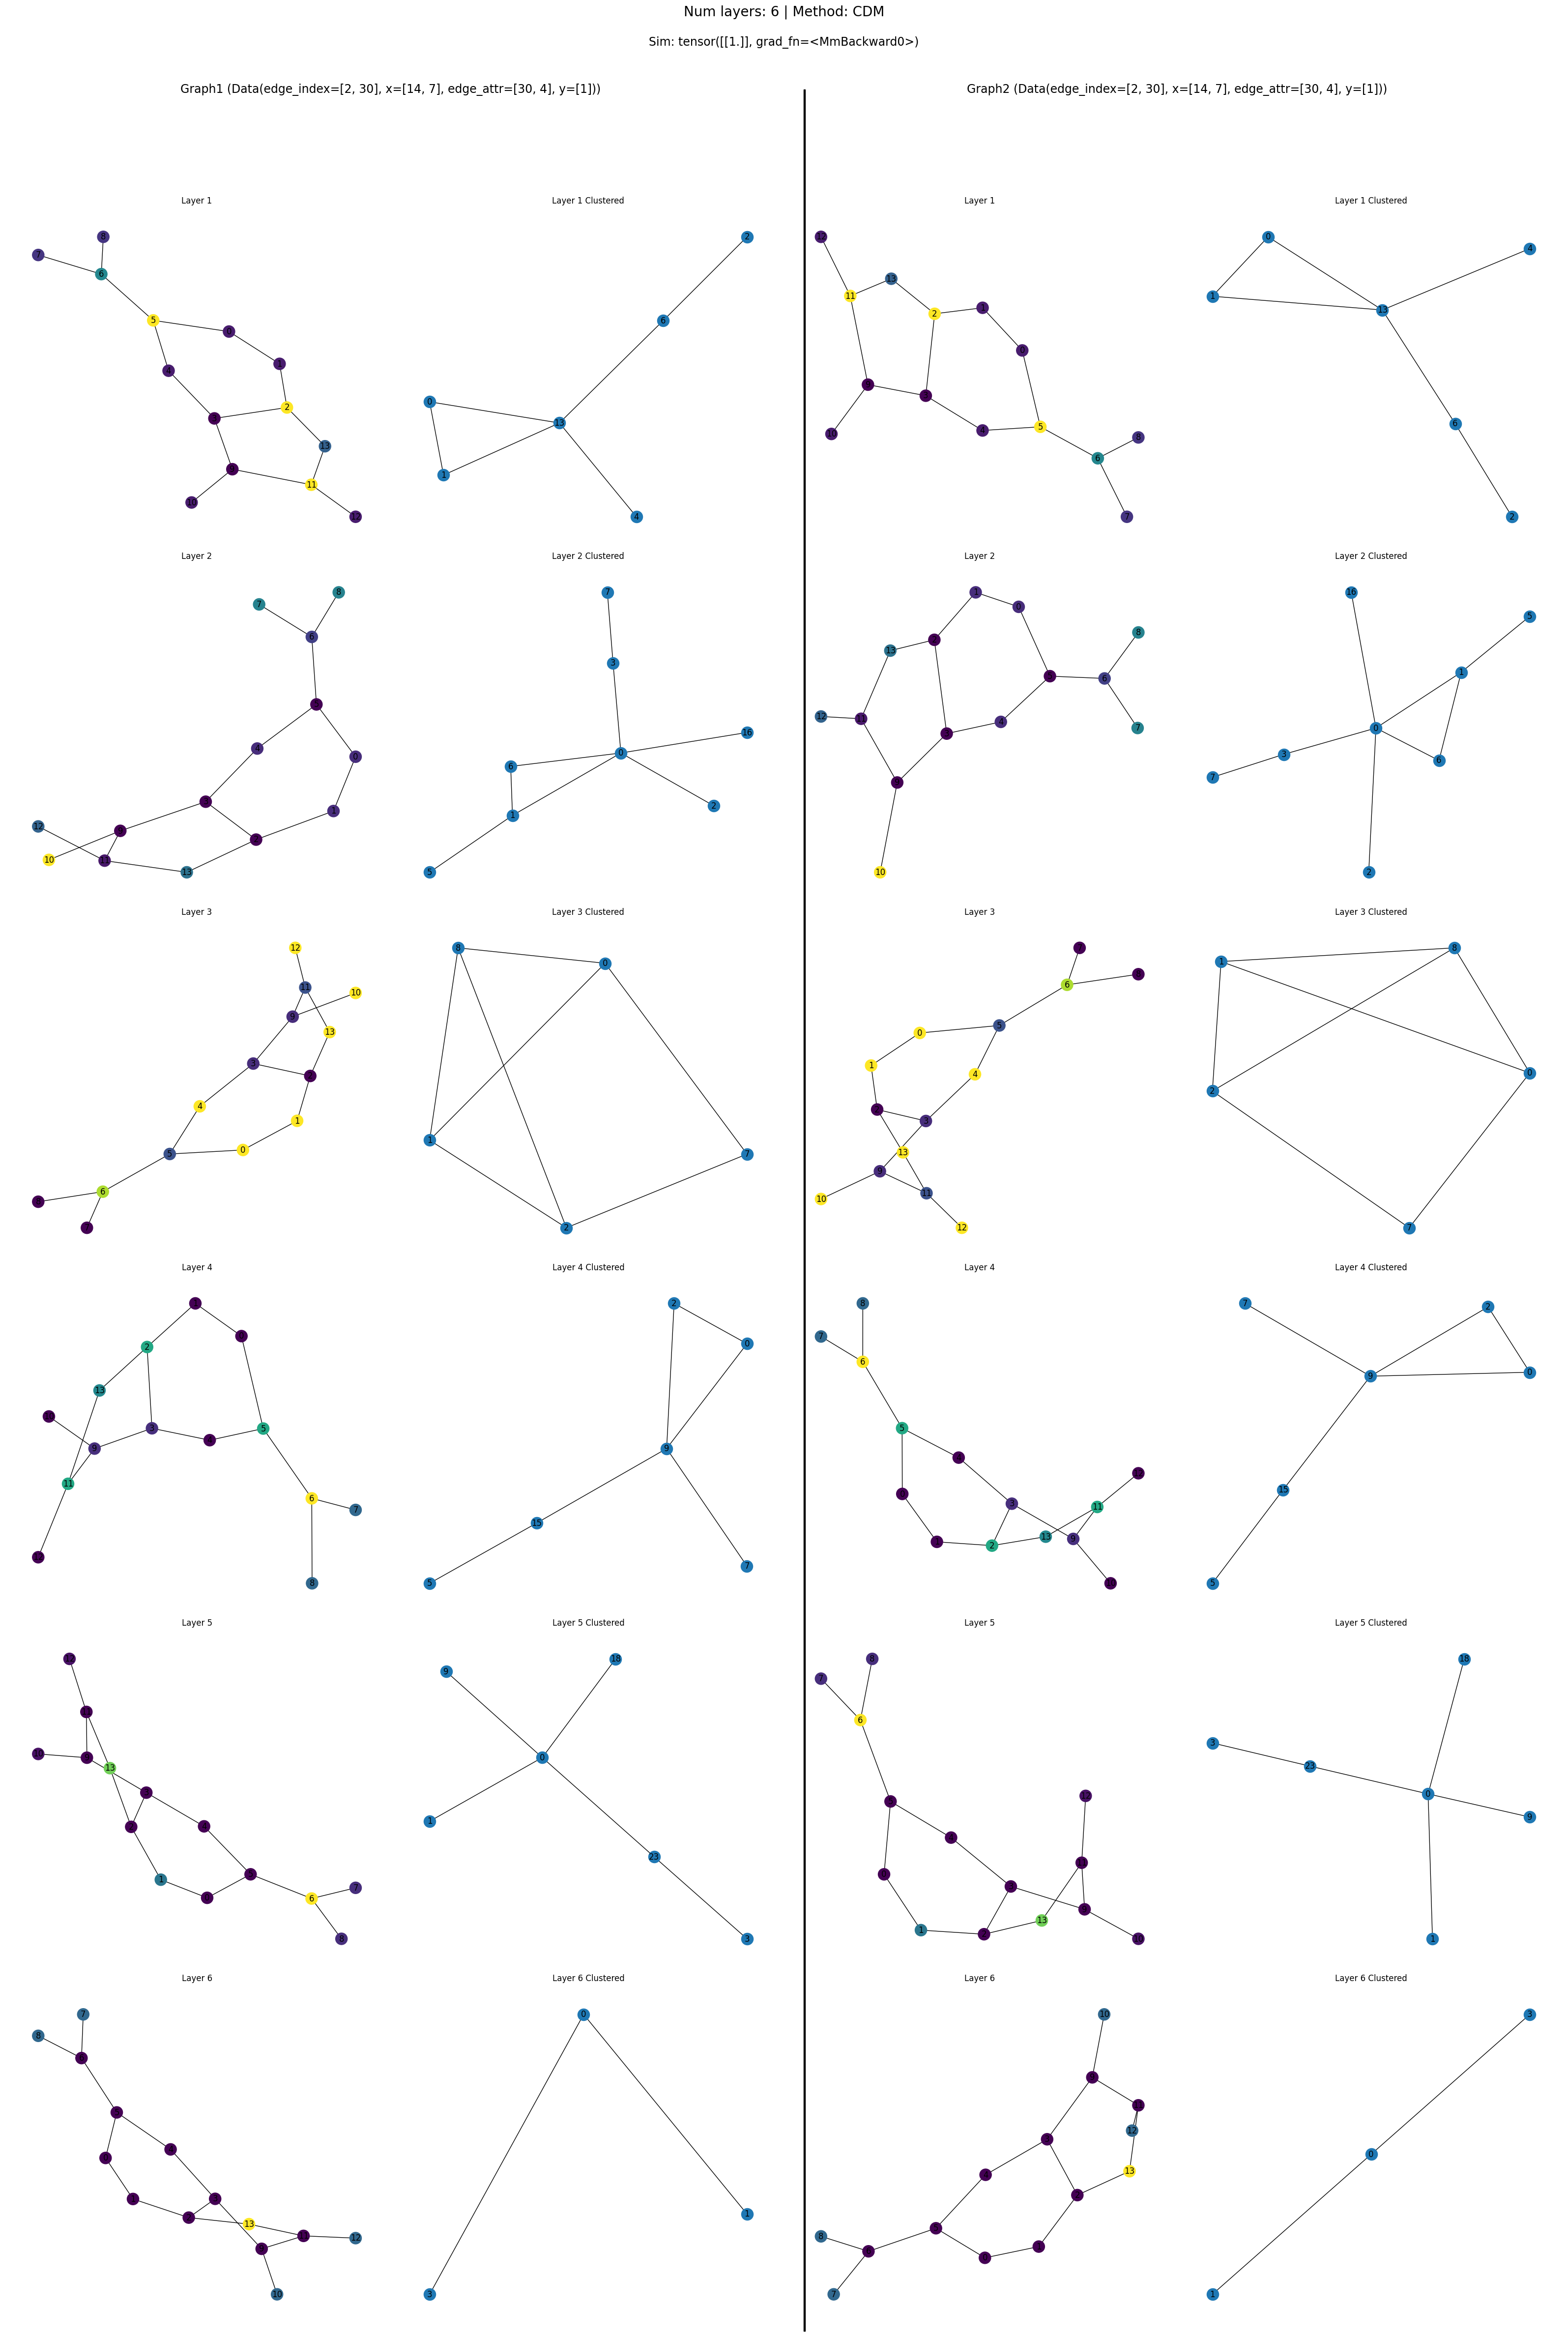

In [ ]:
idx1 = random.sample(range(len(classes["class_0"])), 1)[0]
idx2 = random.sample(range(len(classes["class_0"])), 1)[0]
graph1, graph2 = classes["class_0"][idx1], classes["class_0"][idx2]

model.eval()

label = 1 if graph1.y == graph2.y else -1

feats_1, edge_index_1 = graph1.x, graph1.edge_index
feats_2, edge_index_2 = graph2.x, graph2.edge_index
sizes_1 = torch.tensor([len(graph1.x)])
sizes_2 = torch.tensor([len(graph2.x)])
emb1, emb2 = model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)

sim = pairwise_cosine_similarity(emb1, emb2)
print(f"Similariy: {sim.item(): .4f}")

g1_embeddings = torch.stack([t[0] for t in model.layer_outputs])
g2_embeddings = torch.stack([t[1] for t in model.layer_outputs])

mean_g1 = torch.mean(g1_embeddings, dim=0)
mean_g2 = torch.mean(g2_embeddings, dim=0)

cdm_clusters = []
for o1, o2 in model.layer_outputs:
    cdm_cluster1 = cdm(o1)
    cdm_cluster2 = cdm(o2)
    cdm_clusters.append((cdm_cluster1, cdm_cluster2))


title = f"Num layers: {args.num_layers} | Method: "

plot_graphs(
    [graph1.edge_index, graph2.edge_index],
    cdm_clusters,
    graph1,
    graph2,
    sim,
    title + "CDM",
)

In [ ]:
def normalize_attention(a_x_s):
    a_min, a_max = a_x_s.min(), a_x_s.max()
    if a_max > a_min:
        return (a_x_s - a_min) / (a_max - a_min)
    return a_x_s


def visualize_graphs_with_attention(
    graph1, graph2, a_x_s, a_y_s, threshold=0.9, topk=None
):
    G1 = to_networkx(graph1, to_undirected=True)
    G2 = to_networkx(graph2, to_undirected=True)

    pos1 = nx.kamada_kawai_layout(G1)
    pos2 = nx.kamada_kawai_layout(G2)

    pos2_shifted = {k: [v[0] + 3, v[1]] for k, v in pos2.items()}

    plt.figure(figsize=(24, 14))
    nx.draw(
        G1, pos1, with_labels=True, node_color="skyblue", edge_color="k", node_size=700
    )
    nx.draw(
        G2,
        pos2_shifted,
        with_labels=True,
        node_color="lightcoral",
        edge_color="k",
        node_size=700,
    )

    combined_pos = {**pos1, **{k + len(G1): v for k, v in pos2_shifted.items()}}

    a_x_s = normalize_attention(a_x_s)
    a_y_s = normalize_attention(a_y_s).T

    def keep_topk(tensor, k):
        topk_values, topk_indices = torch.topk(tensor, k=k, dim=1)
        zero_tensor = torch.zeros_like(tensor)
        zero_tensor.scatter_(1, topk_indices, topk_values)

        return zero_tensor

    if topk:
        a_x_s = keep_topk(a_x_s, topk)
        a_y_s = keep_topk(a_y_s, topk)

    for i, j in torch.nonzero(a_x_s > threshold):
        src = i.item()
        target = j.item() + len(G1)
        weight = a_x_s[i, j].item()
        plt.plot(
            [combined_pos[src][0], combined_pos[target][0]],
            [combined_pos[src][1], combined_pos[target][1]],
            color="blue",
            alpha=min(weight * 5, 1.0),
            lw=weight * 2,
        )

    for i, j in torch.nonzero(a_y_s > threshold):
        src = i.item() + len(G1)
        target = j.item()
        weight = a_y_s[i, j].item()
        plt.plot(
            [combined_pos[src][0], combined_pos[target][0]],
            [combined_pos[src][1], combined_pos[target][1]],
            color="red",
            alpha=min(weight * 5, 1.0),
            lw=weight * 2,
        )

    plt.axis("off")
    plt.show()

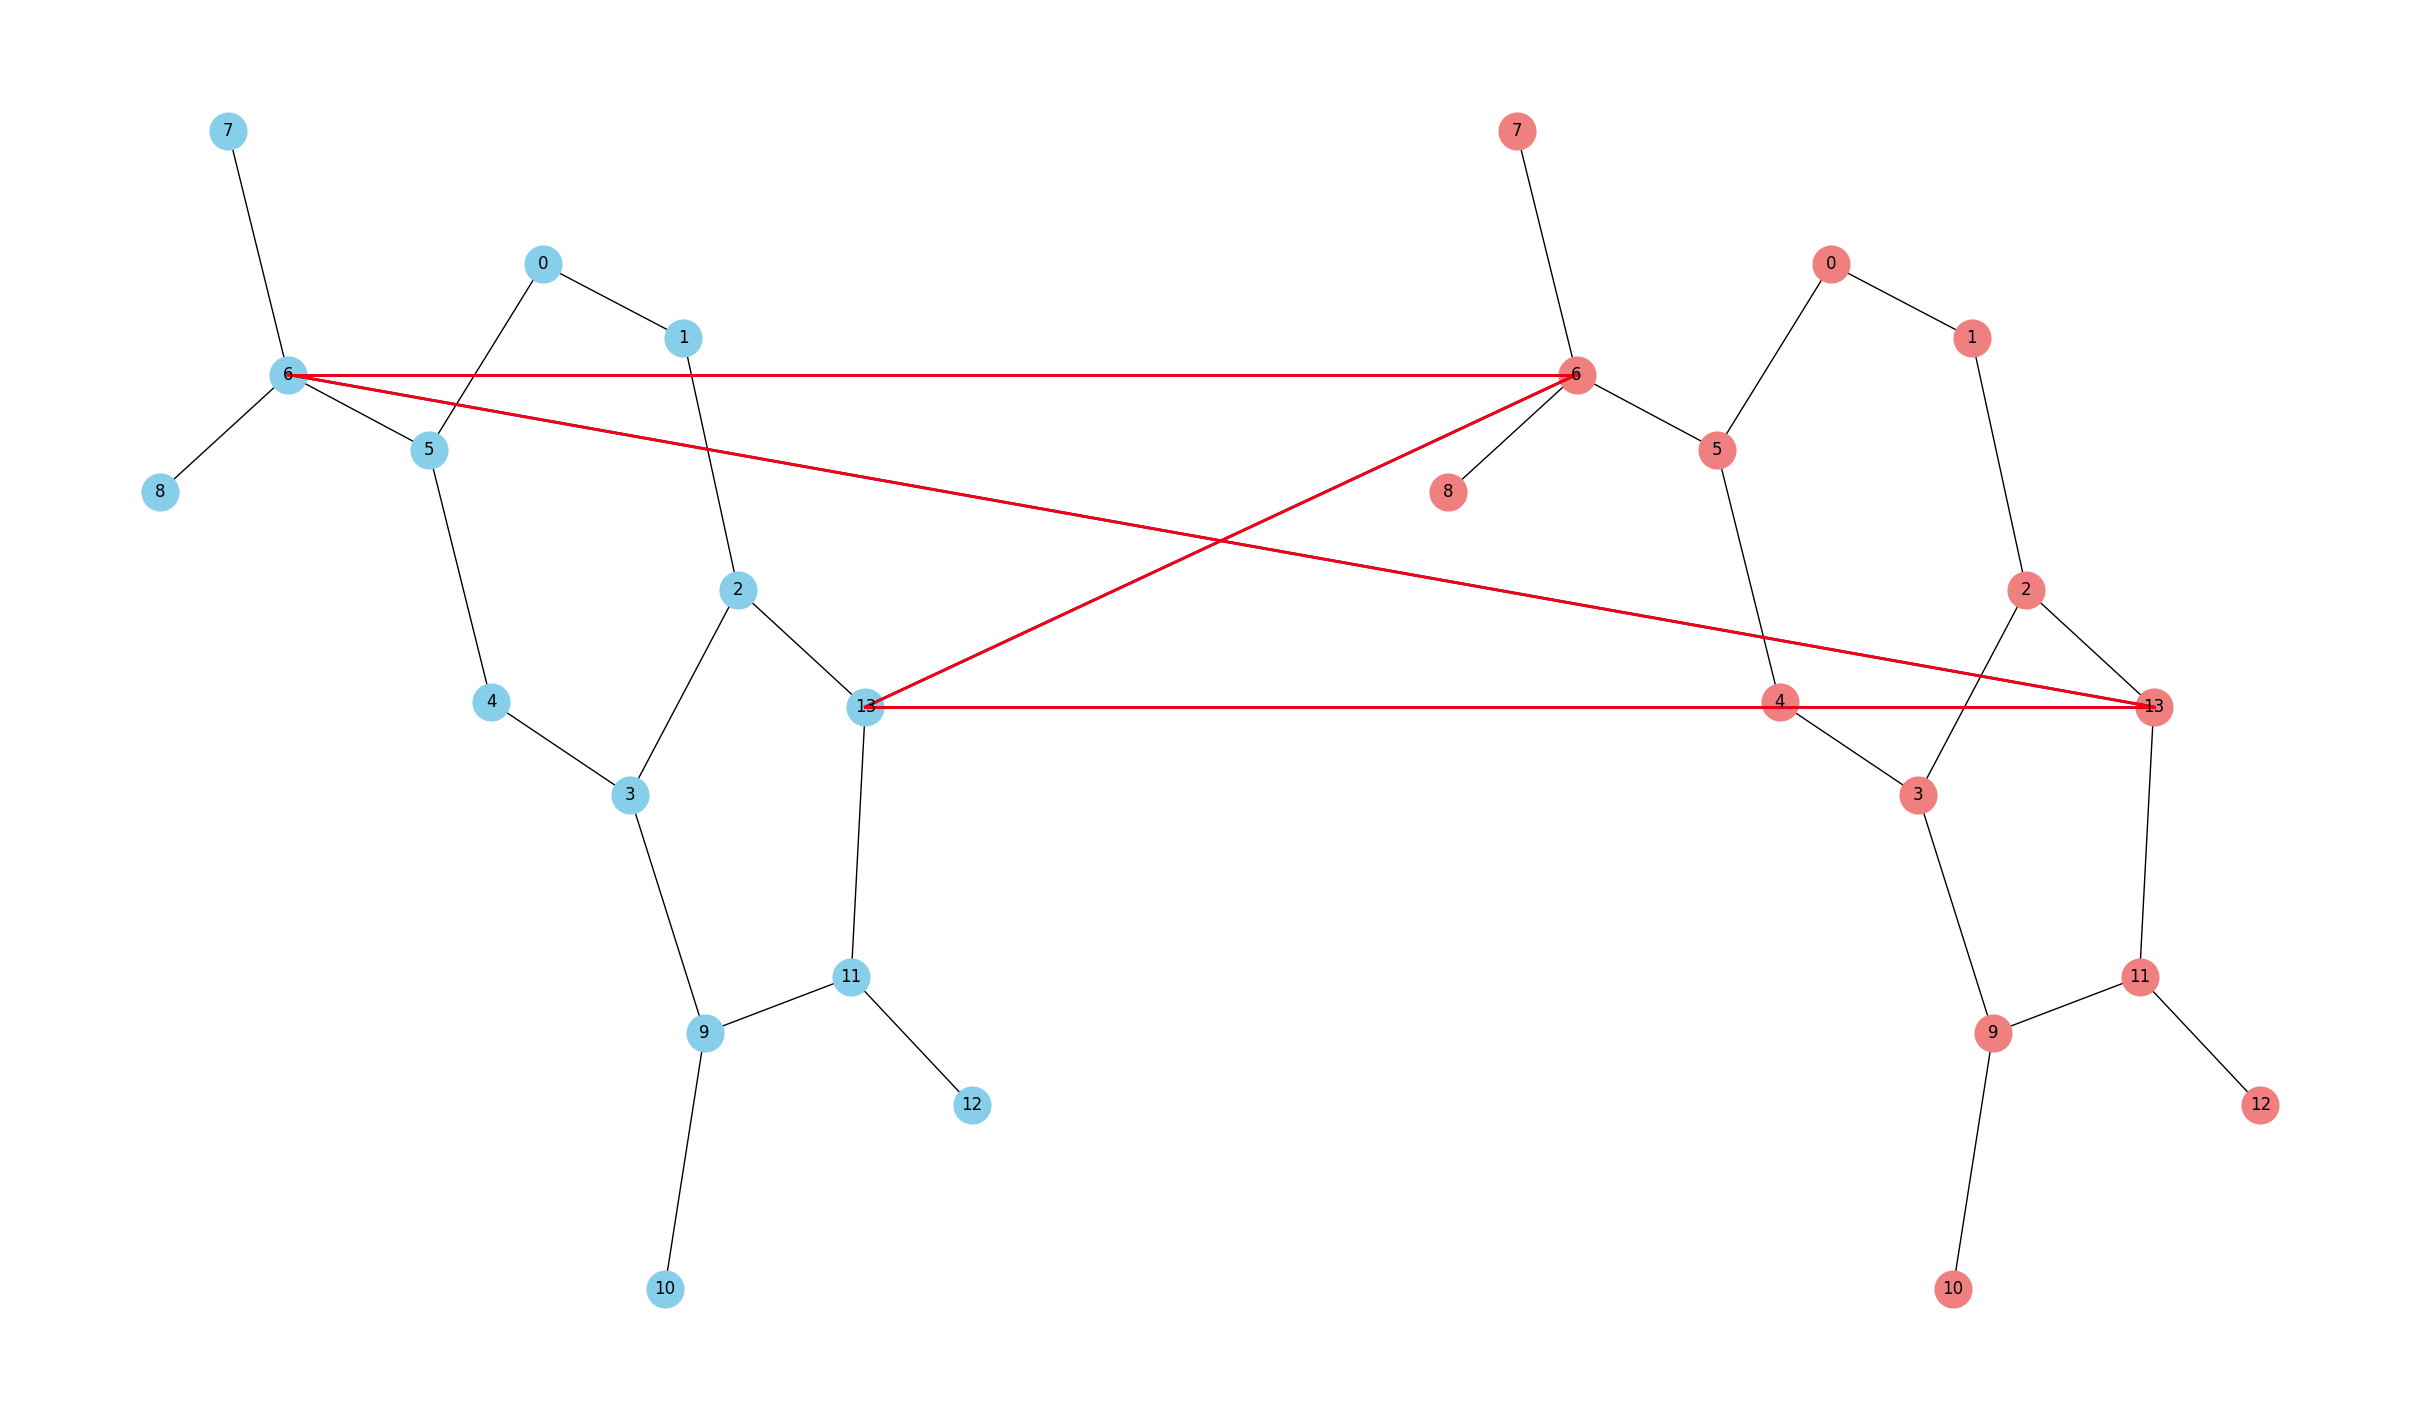

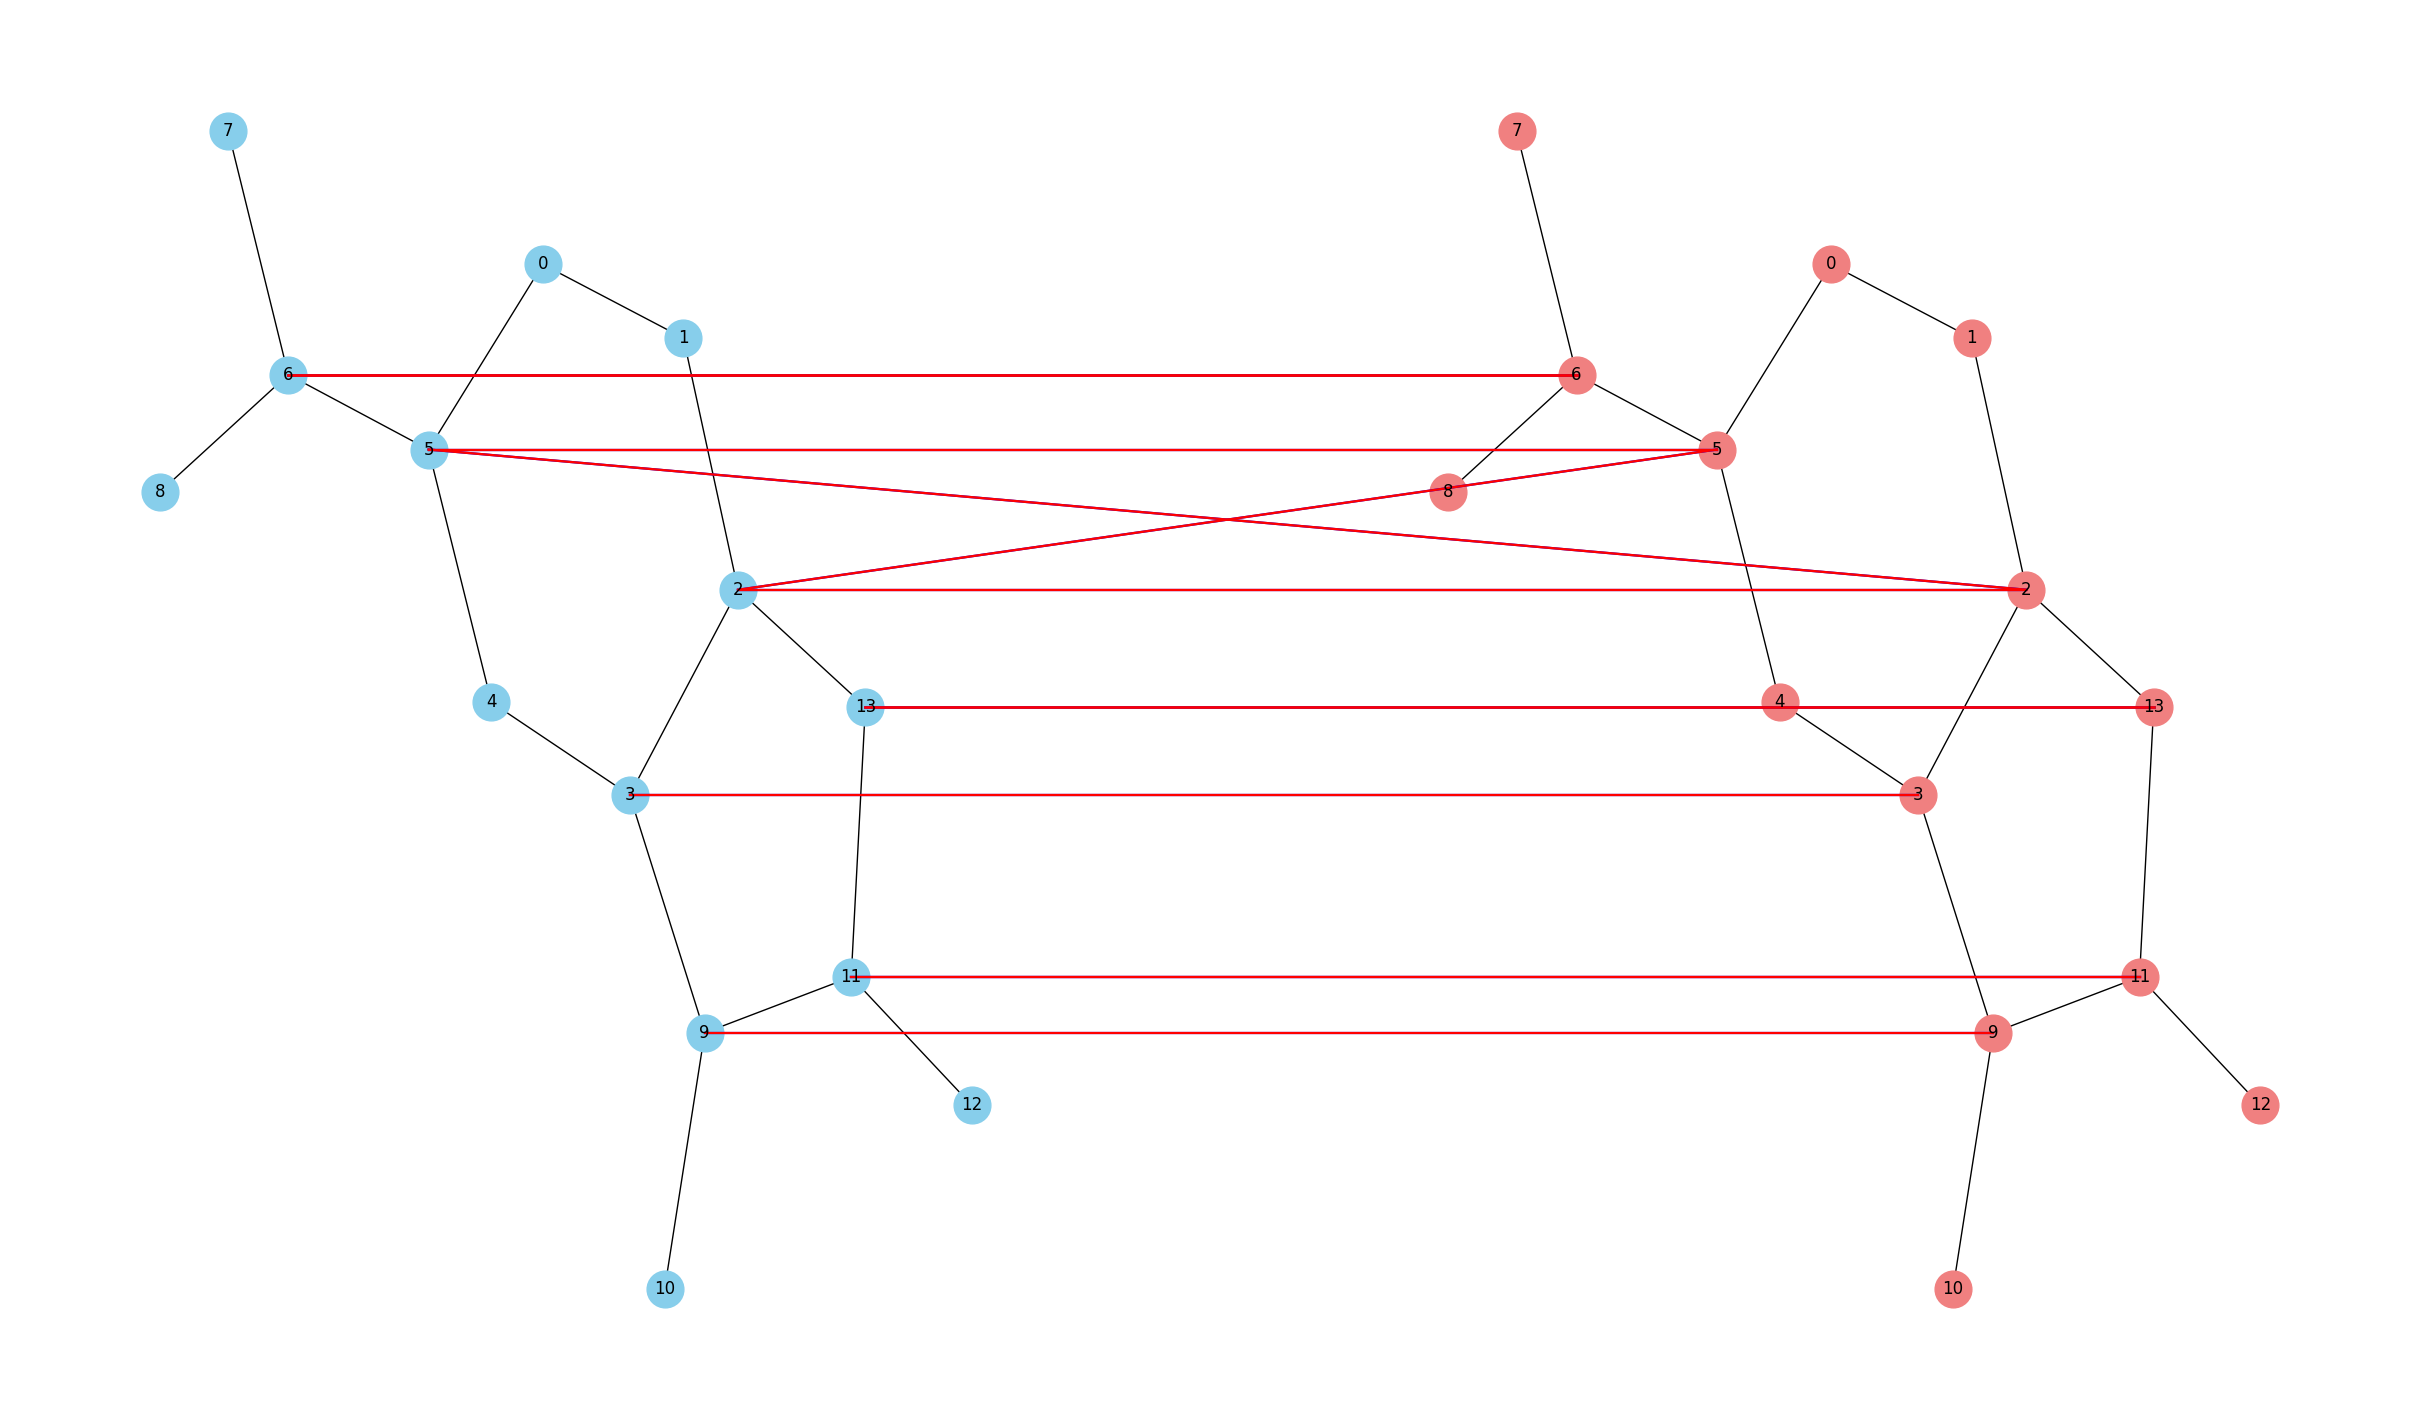

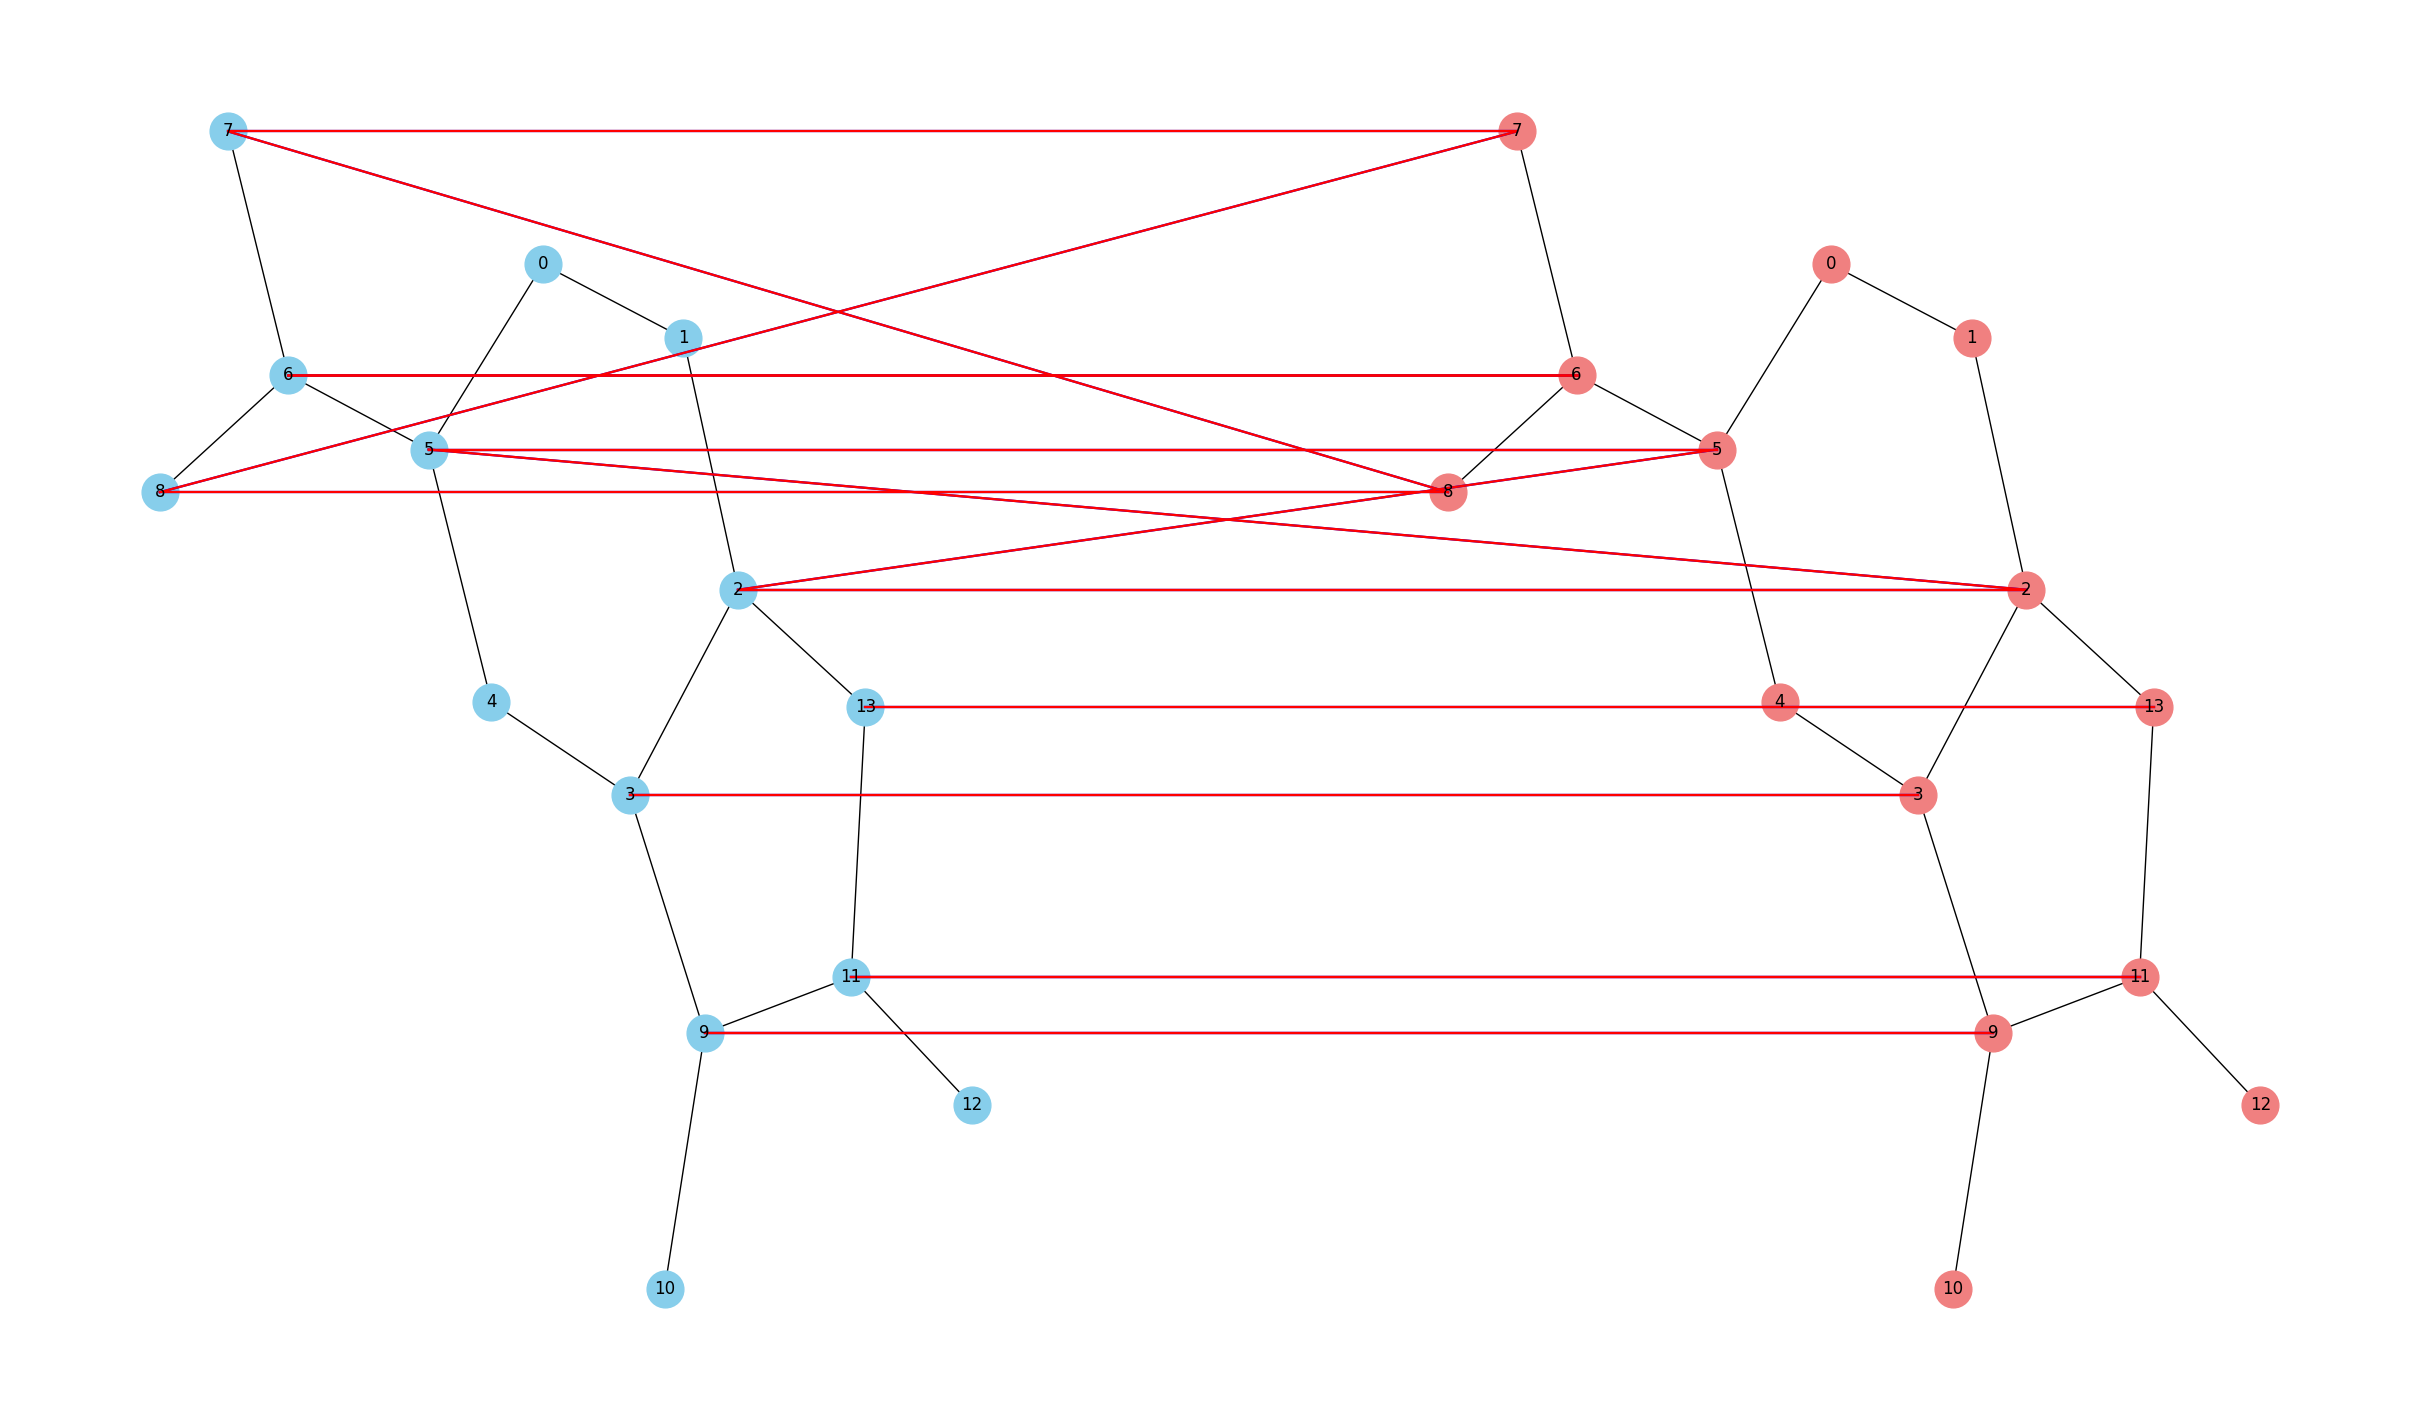

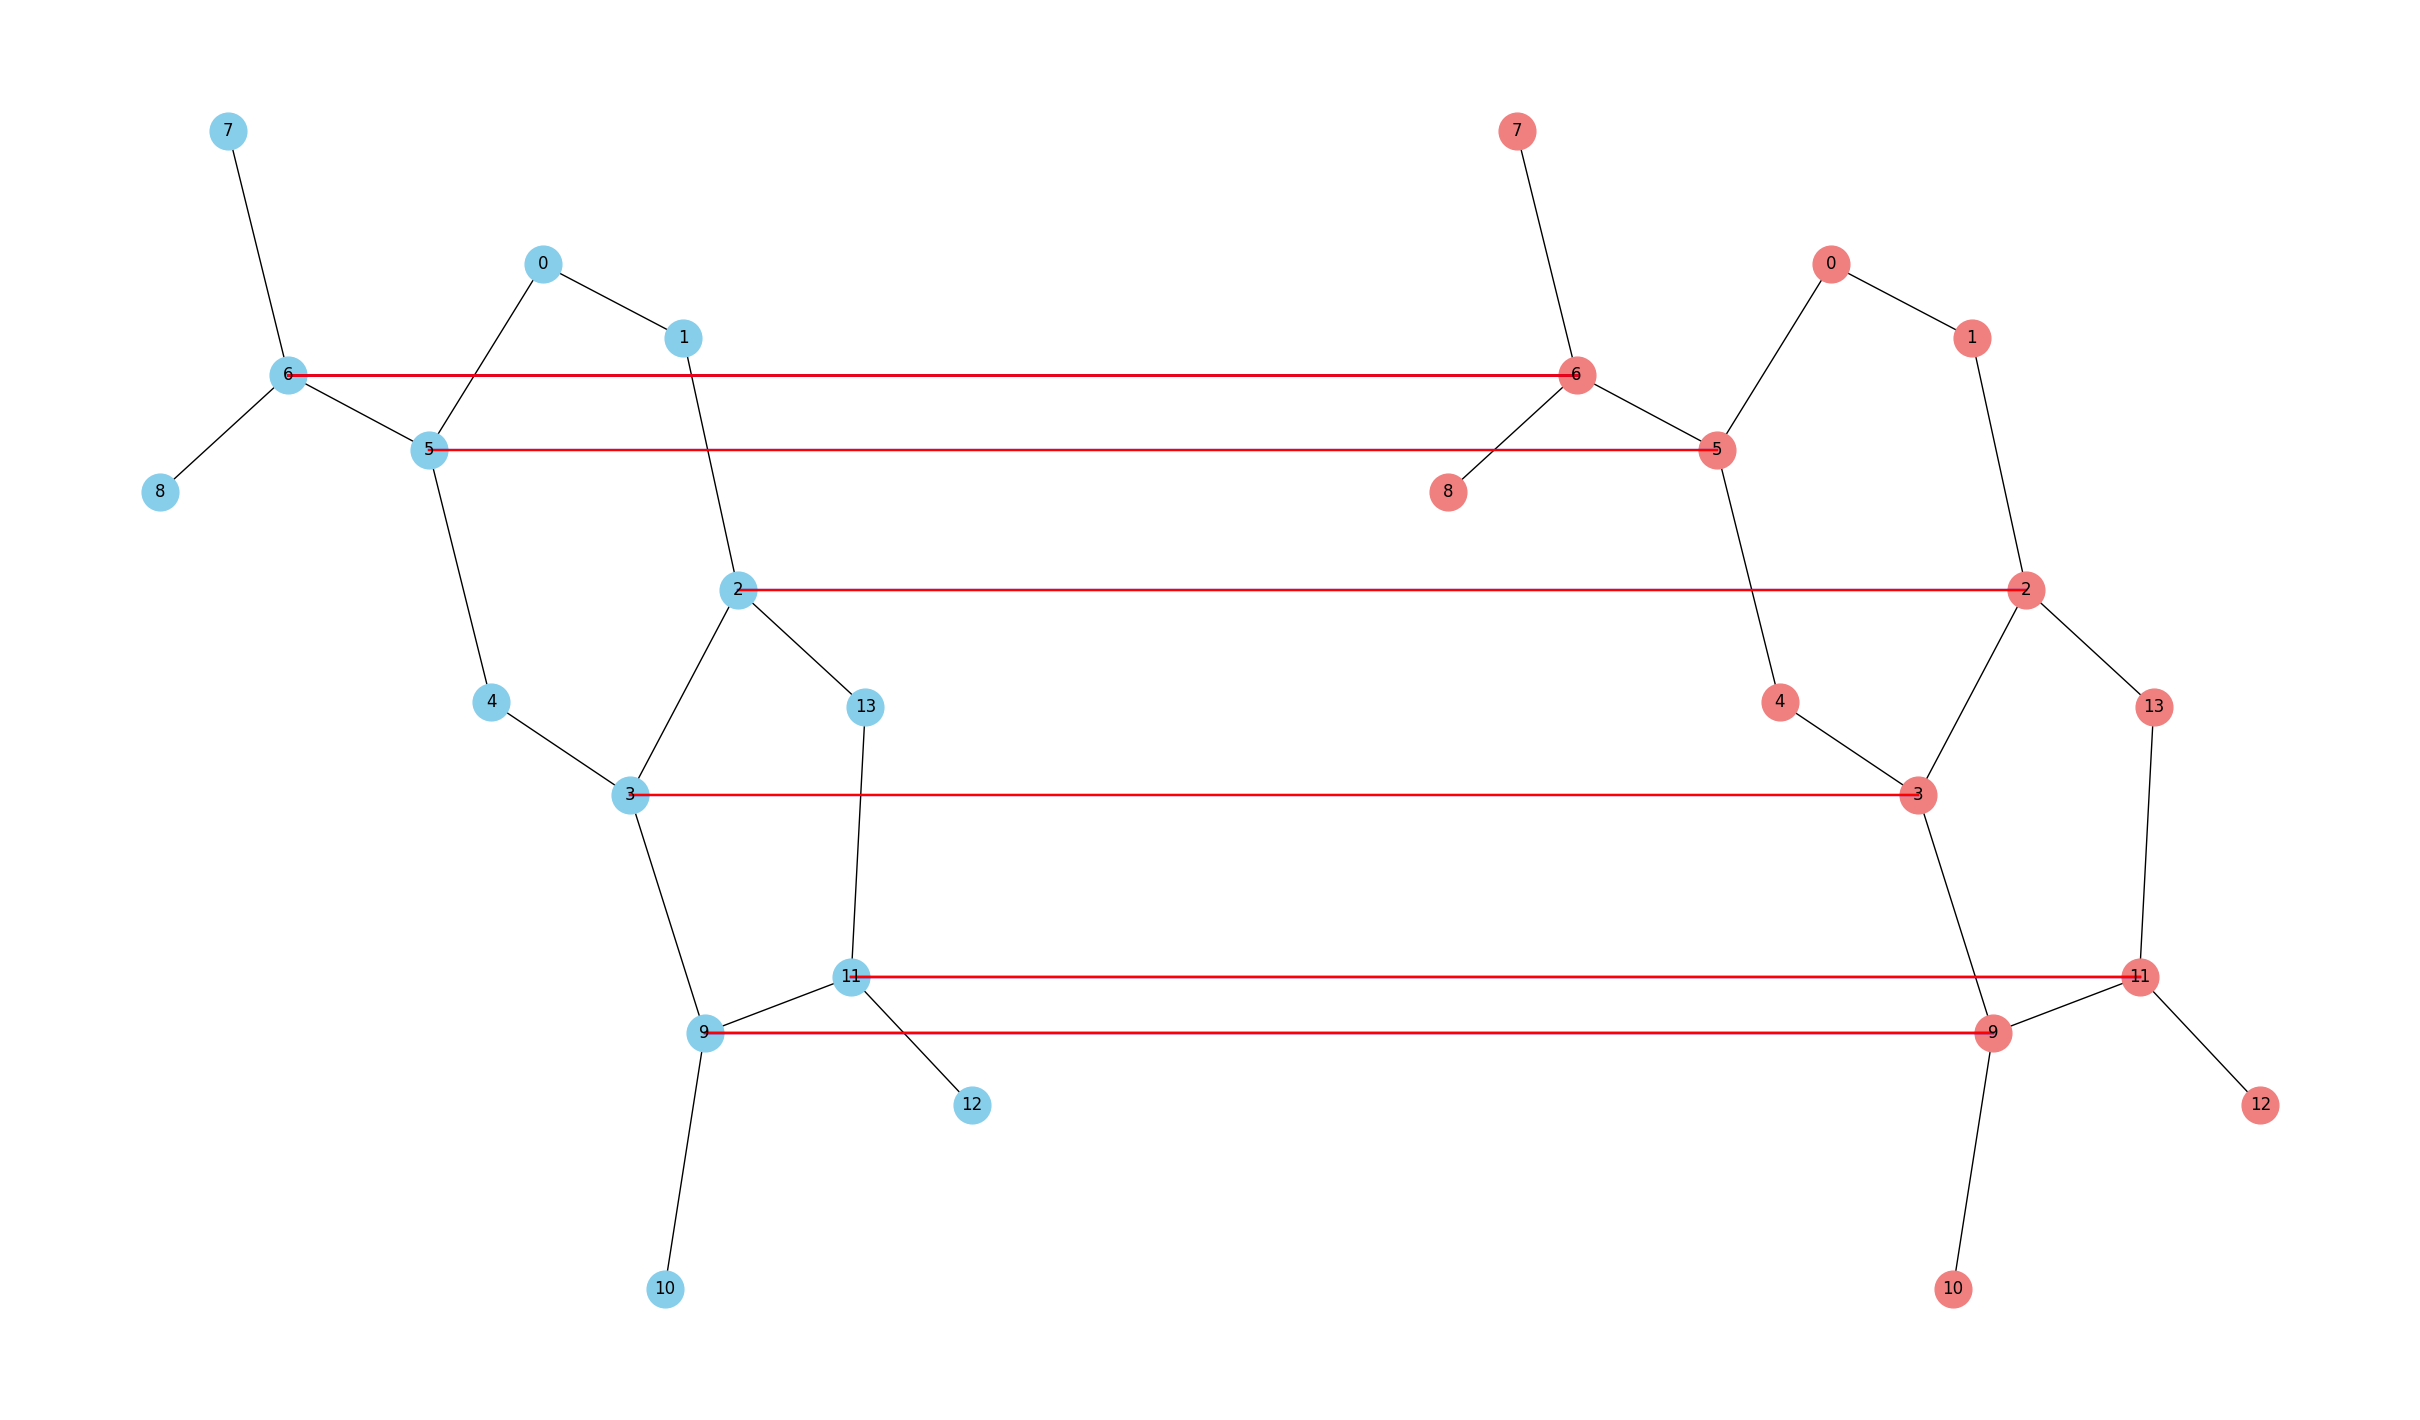

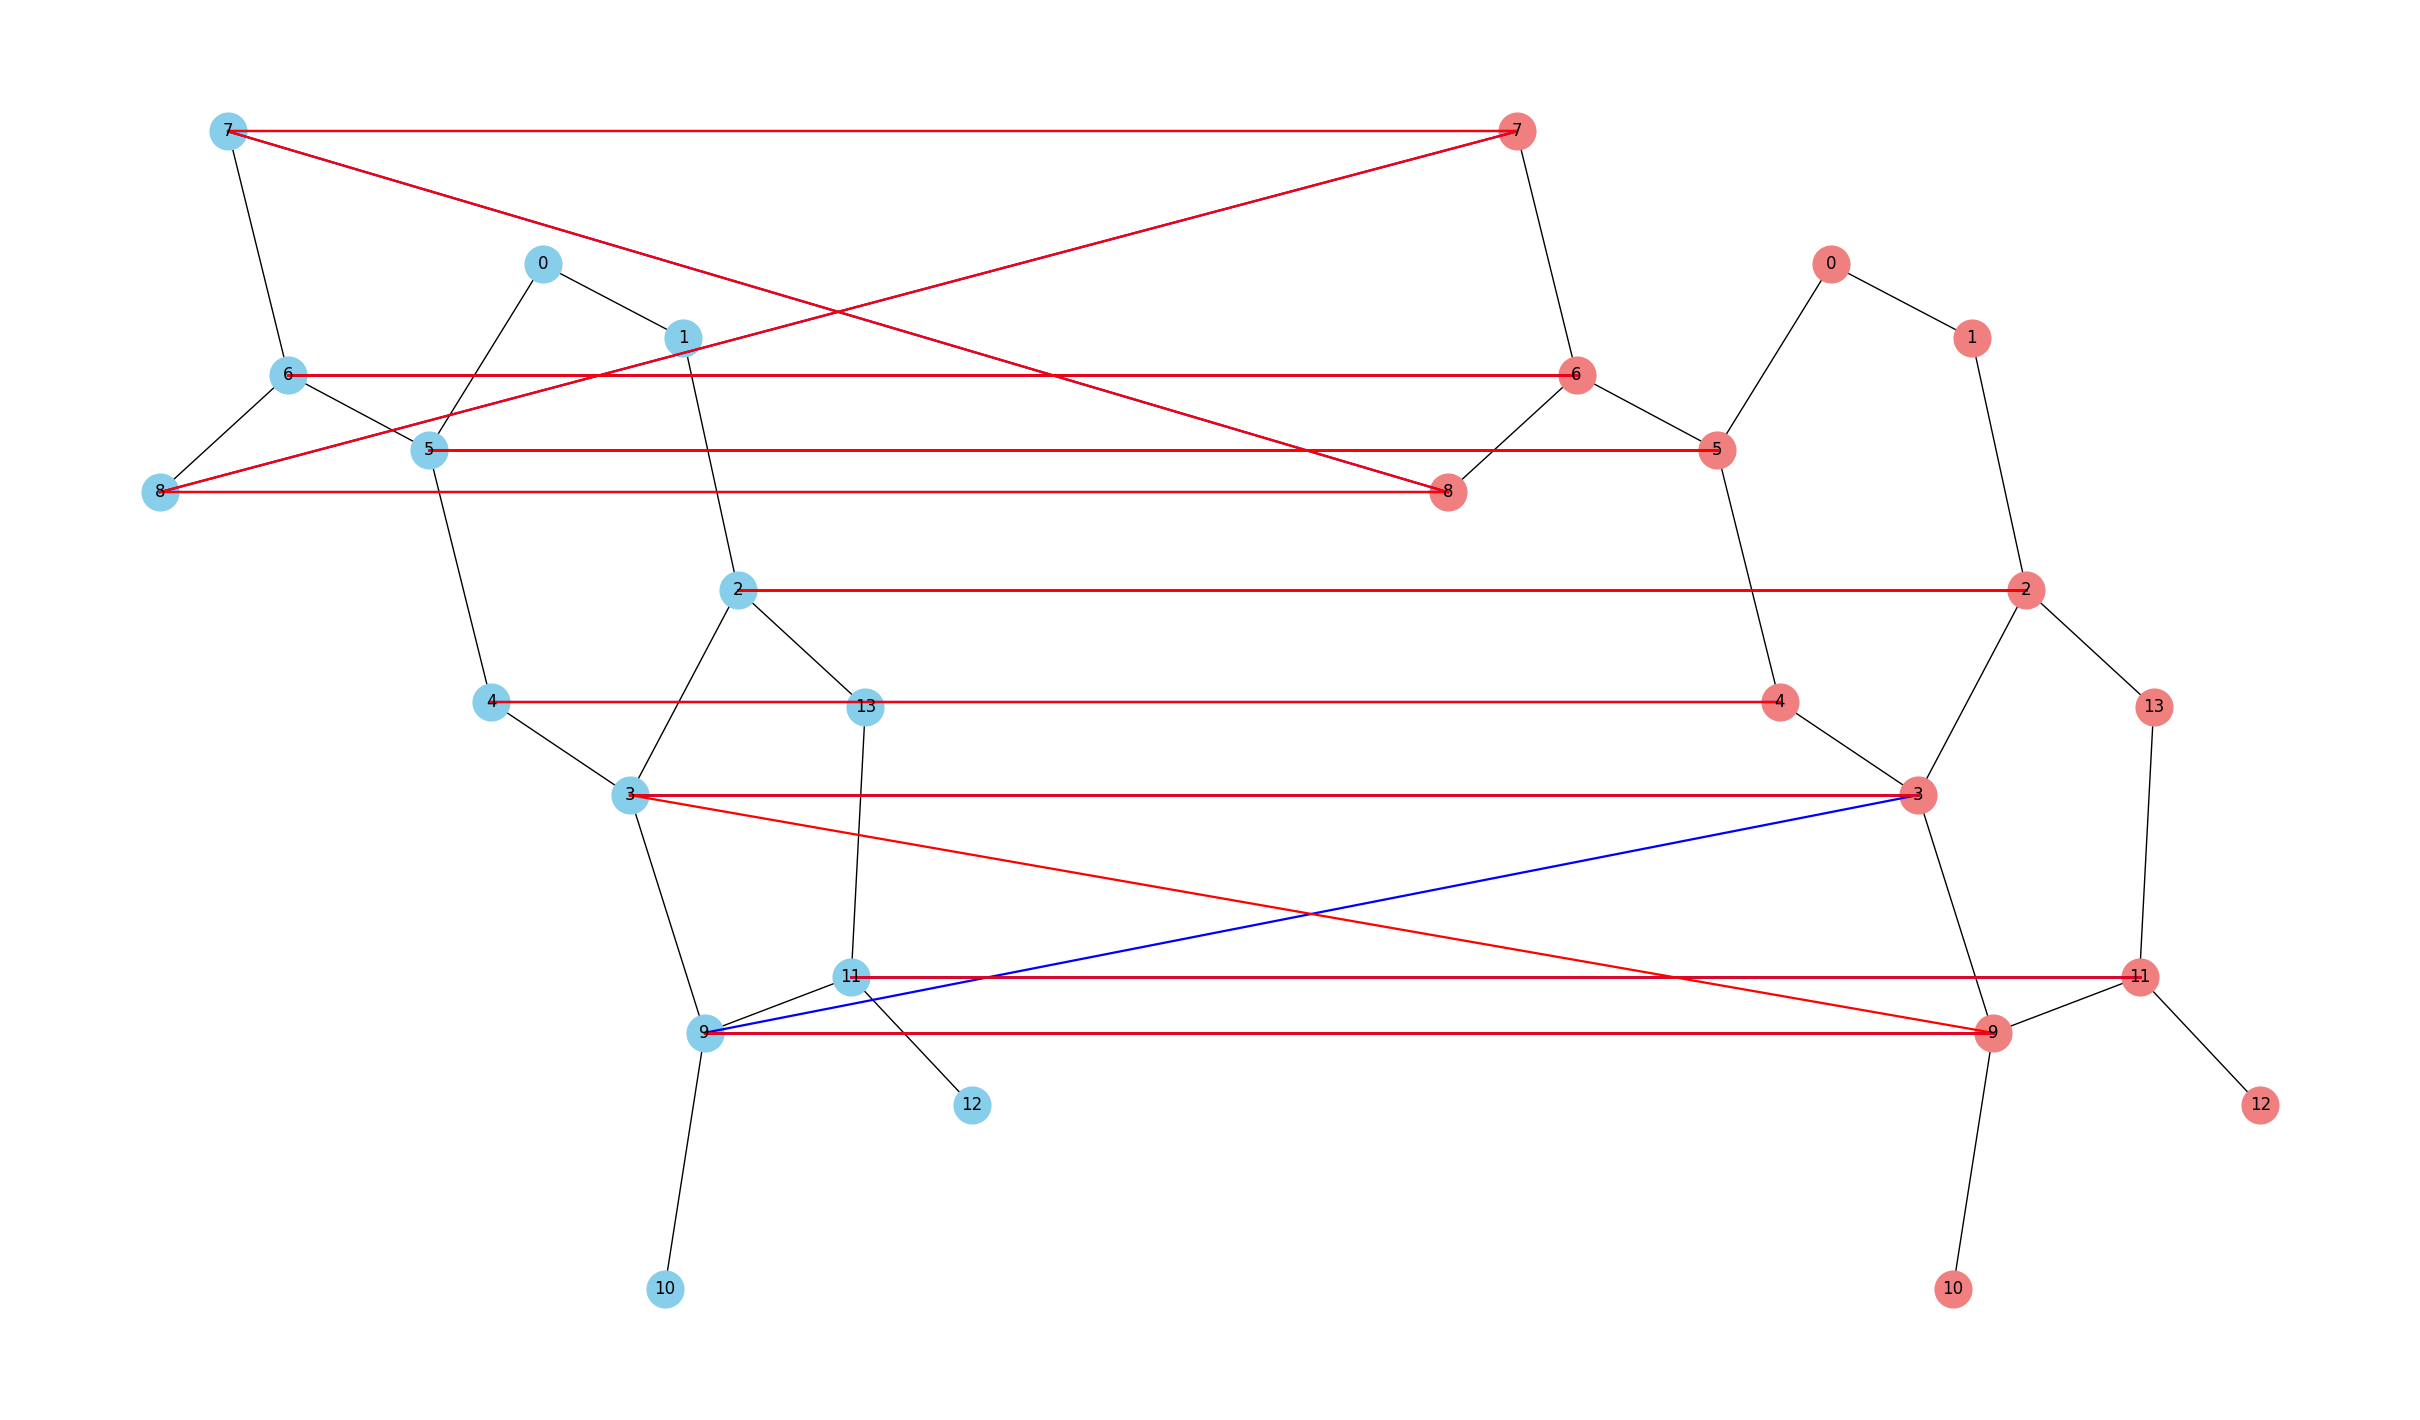

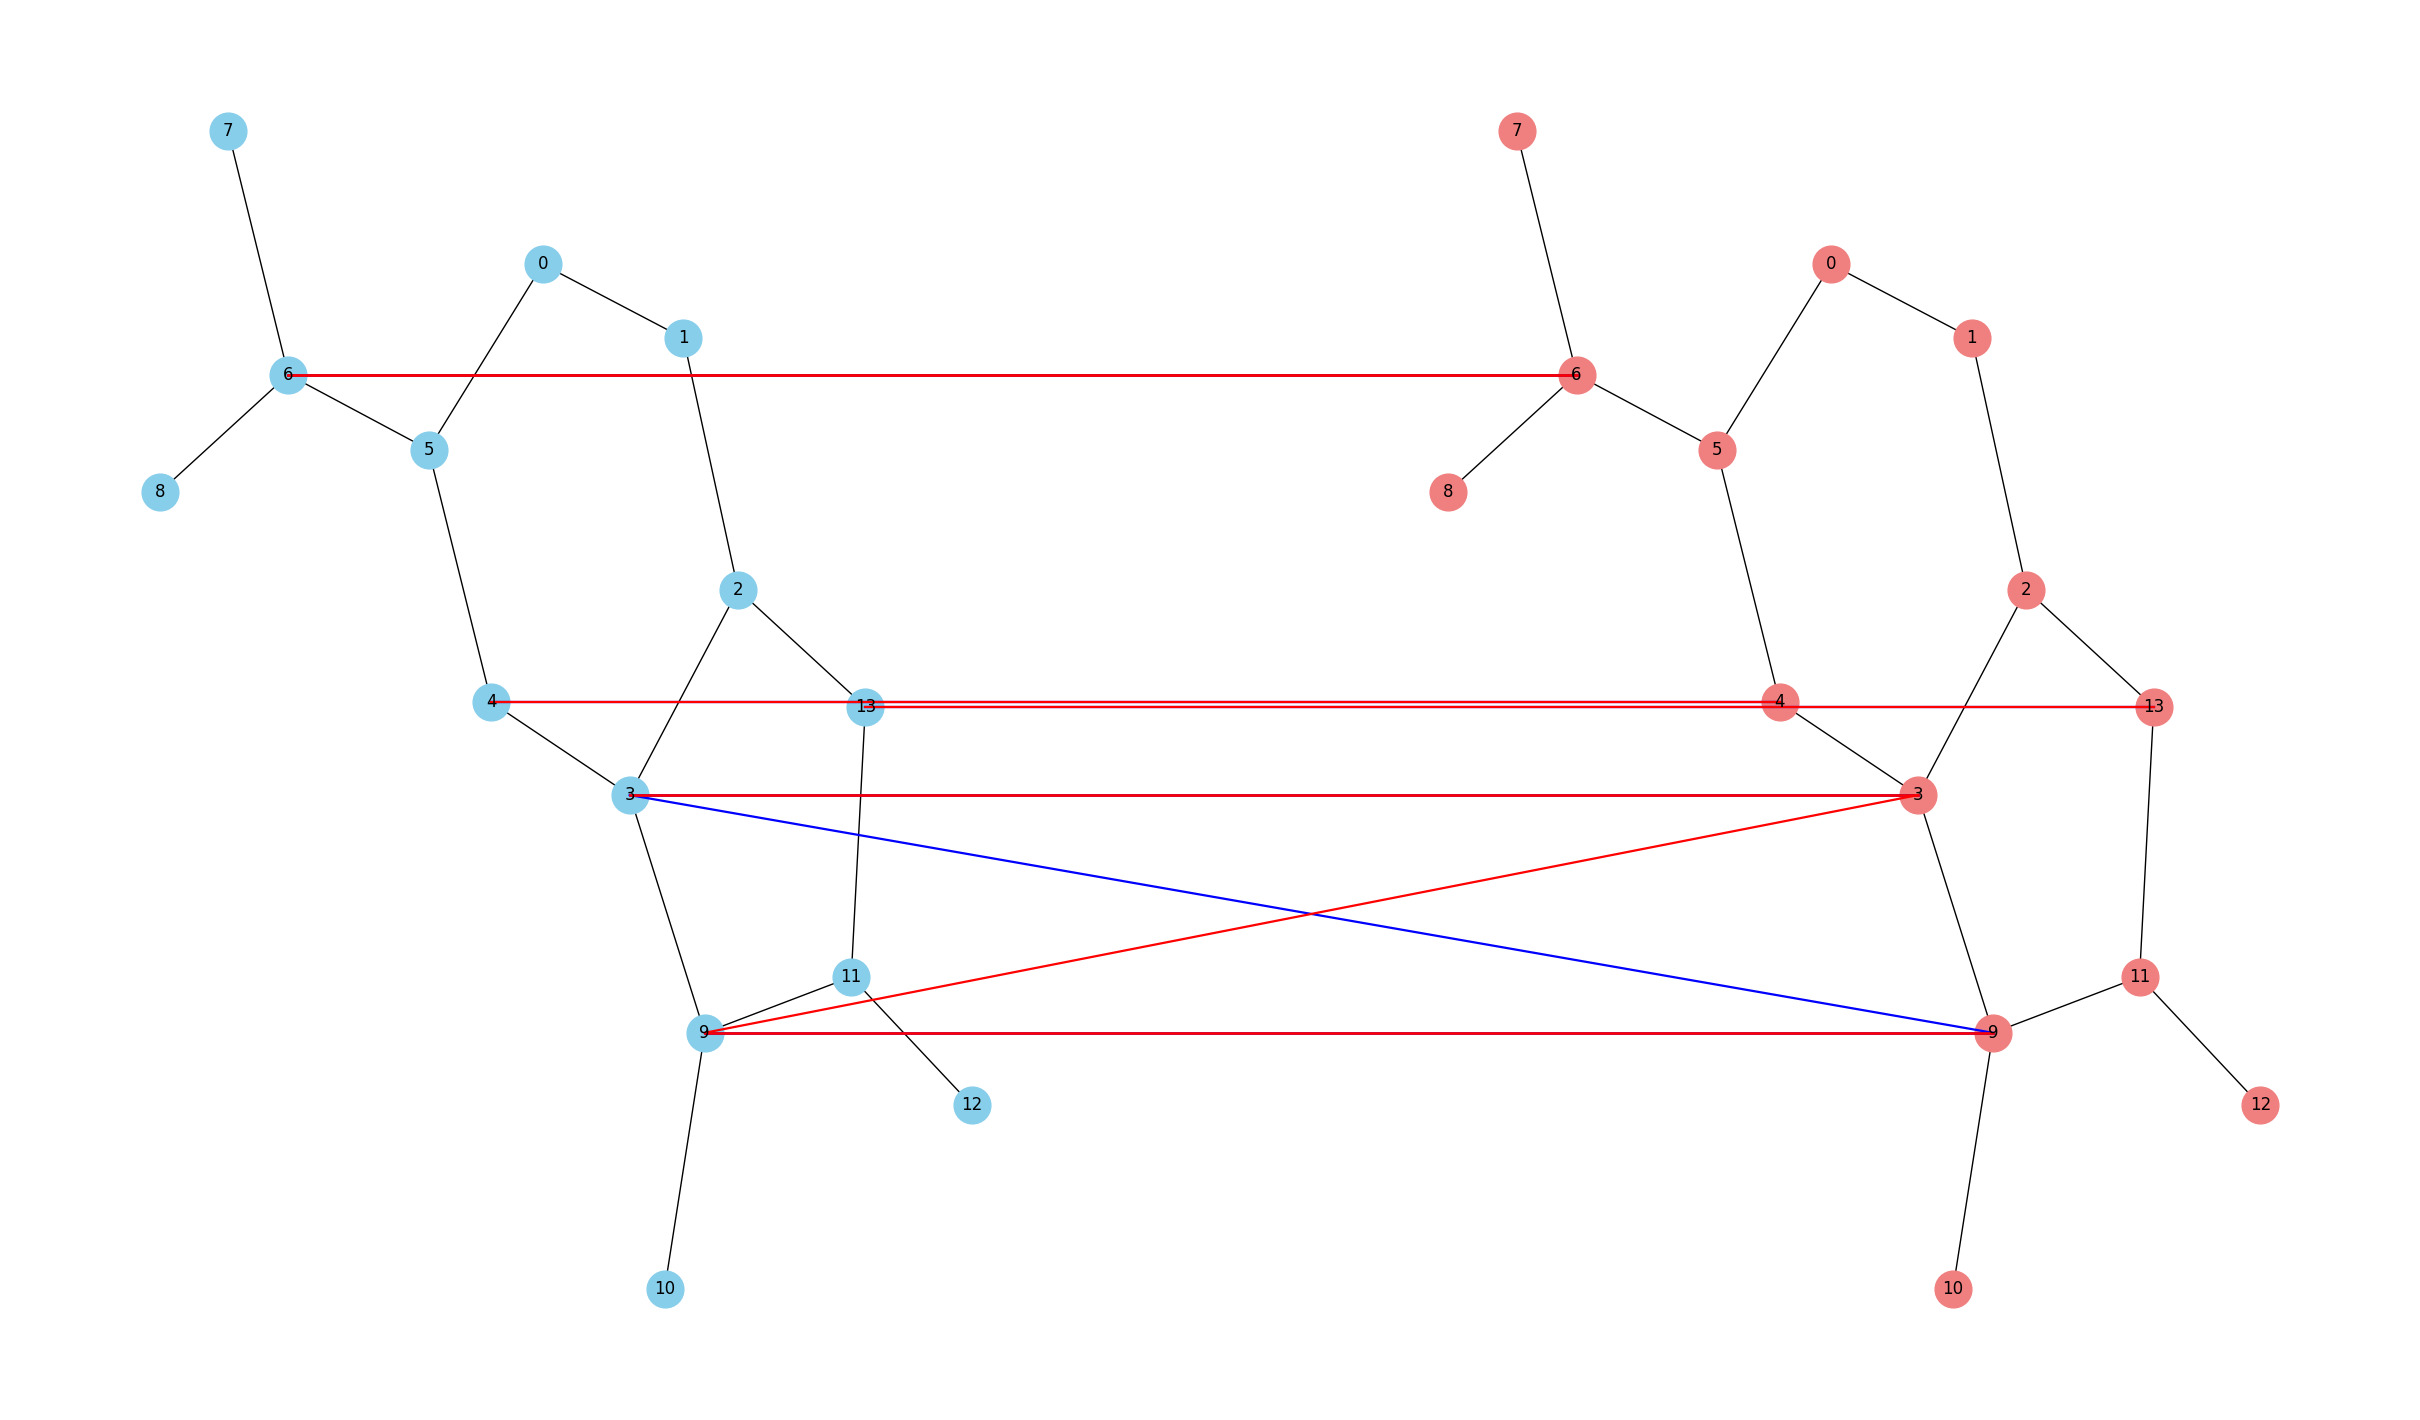

In [ ]:
for i in range(len(model.layer_cross_attentions)):
    cross_attentions, a_x_s, a_y_s = model.layer_cross_attentions[i]
    visualize_graphs_with_attention(
        graph1, graph2, a_x_s[0], a_y_s[0], threshold=0.8, topk=3
    )